<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 1
<br>
<b>Deadline:</b> May 20, 2020 (Wednesday) 23:00
</div>


# Exercise 10.2. Conditional generation with PixelCNN

The goal of this exercise is to do conditional generation with the PixelCNN model.
The basic idea of the conditioning is described in Section 2.3 of [this paper](https://arxiv.org/pdf/1606.05328.pdf). However, we will use a much simpler model.

In [15]:
skip_training = True  # Set this flag to True before validation and submission

In [16]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [17]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [18]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [19]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [20]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data.

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

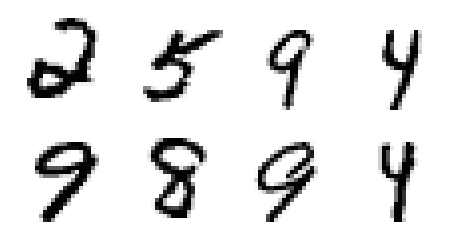

In [22]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])

# Masked convolutional layer

In the cell below, copy the implementation of the `MaskedConv2d` from the PixelCNN notebook.

In [23]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        """
        Args:
          in_channels (int): Number of input channels.
          out_channels (int): Number of output channels.
          kernel_size (int): Kernel size similar to nn.Conv2d layer.
          blind_center (bool): If True, the kernel has zero in the center.
        """
        # YOUR CODE HERE
        super(MaskedConv2d, self).__init__()
        mask = np.zeros([out_channels, in_channels, kernel_size, kernel_size], dtype=np.float32)
        h, w = kernel_size // 2, kernel_size // 2
        if(blind_center == True):
            mask[:, :, :h,:] = 1
            mask[:, :,h, :w ] = 1
        else:
            mask[:, :, :h,:] = 1
            mask[:, :,h, :w + 1] = 1
            
        mask = torch.from_numpy(mask).float().to(device)
        self.register_buffer('mask', mask)
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,  bias = False, padding = padding)
#         raise NotImplementedError()

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, in_channels, height, width): Input images.
        
        Returns:
          y of shape (batch_size, out_channels, height, width): Output images.
        """
        # YOUR CODE HERE
        self.conv.weight.data *= self.mask
        x = self.conv(x)
        return x

# Conditional PixelCNN

Conditional PixelCNN models allows to generate images of a desired class. This can be achieved by providing the desired class label to every layer of the PixelCNN model. In this notebook, we do it in the following way: the input of each masked convolutional layer is:
$$\mathbf{x} + \mathbf{W} \mathbf{h}$$
where
  * $\mathbf{x}$ is the output of the previous layer
  * $\mathbf{h}$ is a 10-dimensional one-hot coded vector of the desired class
  * $\mathbf{W}$ is $c \times 10$ matrix (parameter of a fully-connected layer), where $c$ is the number of input channels in the masked convolutional layer.

You need to implement the conditional PixelCNN model in the cell below.

Recommended architecture:
* Use an architecture similar to the PixelCNN architecture in the first notebook.

In [24]:
class ConditionalPixelCNN(nn.Module):
    def __init__(self, n_channels=64, kernel_size=7):
        """PixelCNN model for conditional generation."""
        # YOUR CODE HERE
        super(ConditionalPixelCNN, self).__init__()
        
#         self.ll0 = nn.Linear(10, 1, bias = False)
        self.maskedcnn = MaskedConv2d(1, n_channels, kernel_size, blind_center=True)
        self.b_norm = nn.BatchNorm2d(n_channels)
        self.ll1 = nn.Linear(10, n_channels, bias = False).to(device)
        self.ll3 = nn.Linear(10, n_channels, bias = False).to(device)
        self.ll2 = nn.Linear(10, n_channels, bias = False).to(device)
        self.ll4 = nn.Linear(10, n_channels, bias = False).to(device)
        self.ll5 = nn.Linear(10, n_channels, bias = False).to(device)
        self.ll6 = nn.Linear(10, n_channels, bias = False).to(device)
        self.ll7 = nn.Linear(10, n_channels, bias = False).to(device)
        self.block1 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block2 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block3 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block4 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block5 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block6 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block7 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        
        self.conv_1x1 = nn.Conv2d(n_channels, 256, kernel_size = 1)
#         raise NotImplementedError()
        
    def compute(self, x, wh):
        wh = wh.T
        wh = wh.reshape(*wh.size(), 1, 1)
        x = x + wh
        return x
    def forward(self, x, labels):
        """Compute logits of the conditional probabilities p(x_i|x_1, ..., x_{i-1}) of the PixelCNN model.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Tensor of input images.
          labels of shape (batch_size): Long tensor of the desired classes of the generated samples.
        
        Returns:
          logits of shape (batch_size, 256, 28, 28): Tensor of logits of the conditional probabilities
                                                      for each pixel.
        
        NB: Do not use softmax nonlinearity after the last layer.
        """
        # YOUR CODE HERE
        y = torch.eye(10).to(device)
        one_hot = y[labels]
        one_hot = one_hot.to(device)
        
        x = F.relu(self.b_norm(self.maskedcnn(x)))        
        linear_temp = self.ll1(one_hot)
        # wh = wh.T.reshape(*wh.size(), 1, 1)
        # x = x + wh
        x = self.compute(x, torch.mm(self.ll1.weight.data, (one_hot.T)))
        x = self.block1(x)
        
        linear_temp = self.ll2(one_hot)
        x = self.compute(x, torch.mm(self.ll2.weight.data, (one_hot.T)))
        x = self.block2(x)

        linear_temp = self.ll3(one_hot)
        x = self.compute(x, torch.mm(self.ll3.weight.data, (one_hot.T)))
        x = self.block3(x)

        linear_temp = self.ll4(one_hot)
        x = self.compute(x, torch.mm(self.ll4.weight.data, (one_hot.T)))
        x = self.block4(x)
        
        linear_temp = self.ll5(one_hot)
        x = self.compute(x, torch.mm(self.ll5.weight.data, (one_hot.T)))
        x = self.block5(x)
        
        linear_temp = self.ll6(one_hot)
        x = self.compute(x, torch.mm(self.ll6.weight.data, (one_hot.T)))
        x = self.block6(x)
        
        linear_temp = self.ll7(one_hot)
        x = self.compute(x, torch.mm(self.ll7.weight.data, (one_hot.T)))
        x = self.block7(x)
        
        x = self.conv_1x1(x)
        return x
#         raise NotImplementedError()

In [25]:
def test_ConditionalPixelCNN_shapes():
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)

    batch_size = 2
    x = torch.ones(batch_size, 1, 28, 28)
    labels = torch.zeros(batch_size, dtype=torch.long)
    y = net(x, labels)
    assert y.shape == torch.Size([batch_size, 256, 28, 28]), f"Bad y.shape: {y.shape}"
    print('Success')

test_ConditionalPixelCNN_shapes()

Success


### Loss function for training conditional PixelCNN

The `loss_fn()` function is identical to the `loss_fn()` from the PixelCNN notebook.

In [26]:
def generate(net, labels, image_size=(28, 28), device='cpu'):
    """Generate samples using a trained conditional PixelCNN model.
    Note: use as device labels.device.

    Args:
      net: Conditional PixelCNN model.
      labels of shape (n_samples): Long tensor of the desired classes of the generated samples.
      image_size: Tuple of image size (height, width).
      device:     Device to use.
    
    Returns:
      samples of shape (n_samples, 1, height, width): Generated samples.
    """
    # YOUR CODE HERE
    n_samples = labels.shape[0]
    sample = torch.Tensor(n_samples, 1, image_size[0], image_size[1]).to(device)
    sample.fill_(0)

    for i in range(image_size[0]):
        for j in range(image_size[0]):
            net.eval()
            out = net(sample, labels)
            probs = F.softmax(out[:,:,i,j], dim = 1).data
            # print(torch.multinomial(probs, 1).float())
            sample[:,:,i,j] = torch.multinomial(probs, 1) / 255.0

    return sample
#     raise NotImplementedError()

### Generation procedure

The `generate()` function is *almost* identical to the `generate()` function from the PixelCNN notebook. It additionally receives the labels of the desired classes so that they can be used in the forward computations of the conditional PixelCNN model.

In [27]:
def generate(net, labels, image_size=(28, 28), device='cpu'):
    """Generate samples using a trained conditional PixelCNN model.
    Note: use as device labels.device.

    Args:
      net: Conditional PixelCNN model.
      labels of shape (n_samples): Long tensor of the desired classes of the generated samples.
      image_size: Tuple of image size (height, width).
      device:     Device to use.
    
    Returns:
      samples of shape (n_samples, 1, height, width): Generated samples.
    """
    # YOUR CODE HERE
    sample = torch.Tensor(n_samples, 1, image_size[0], image_size[1]).to(device)
    sample.fill_(0)

    for i in range(image_size[0]):
        for j in range(image_size[0]):
            net.eval()
            out = net(sample, labels)
            probs = F.softmax(out[:,:,i,j], dim = 1).data
            # print(torch.multinomial(probs, 1).float())
            sample[:,:,i,j] = torch.multinomial(probs, 1) / 255.0

    return sample
#     raise NotImplementedError()

# Train the model

In [28]:
# Create network
net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
net.to(device)

ConditionalPixelCNN(
  (maskedcnn): MaskedConv2d(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  )
  (b_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ll1): Linear(in_features=10, out_features=64, bias=False)
  (ll3): Linear(in_features=10, out_features=64, bias=False)
  (ll2): Linear(in_features=10, out_features=64, bias=False)
  (ll4): Linear(in_features=10, out_features=64, bias=False)
  (ll5): Linear(in_features=10, out_features=64, bias=False)
  (ll6): Linear(in_features=10, out_features=64, bias=False)
  (ll7): Linear(in_features=10, out_features=64, bias=False)
  (block1): Sequential(
    (0): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaskedConv2d(
      (conv): Conv2d(64, 

In [29]:
# Plot generated samples for an untrained model
# Note: generation on CPU may take a significant amount of time
if not skip_training:
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 11.

Hints:
- The loss values are similar to the loss values in the PixelCNN notebook.
- Please use this code to plot 120 generated samples after each epoch. This will allow you to track the training progress.
```
# Generate samples
with torch.no_grad():
    net.eval()
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)
```
- The generated images should be of great quality but you should definitely recognize the desired classes of the digits.
- **Do not forget to set the model into the training mode by `net.train()` before training.**

In [30]:
import time
if not skip_training:
    # YOUR CODE HERE
    time_start = time.time()
    epochs = 11
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    for i in range(epochs):
        net.train()
        step = 0
        loss_= 0
        for images, labels in trainloader:
            images = images.to(device)
            
            optimizer.zero_grad()
            
            output = net(images, labels)
            
            loss = loss_fn(output, images)
            
            loss.backward()
            optimizer.step()

            step += 1

            if(step%100 == 0):
                print('Epoch:'+str(i)+'\t'+ str(step) +'\t Iterations Complete \t'+'loss: ', loss.item())
        print('Epoch: '+str(i)+' Over!')
        with torch.no_grad():
          net.eval()
          labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
          samples = generate(net, labels, device=device)
          tools.plot_generated_samples(samples, ncol=10)
    print('Training Finished! Time Taken: ', time.time()-time_start)
#     raise NotImplementedError()

In [31]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(net, '10_cond_pixelcnn.pth')
else:
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
    tools.load_model(net, '10_cond_pixelcnn.pth', device)

Model loaded from 10_cond_pixelcnn.pth.


### Generate samples

In [32]:
if not skip_training:
    with torch.no_grad():
        net.eval()
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        samples = generate(net, labels, device=device)
        tools.plot_generated_samples(samples, ncol=10)

In [33]:
# This cell tests the training loss of the trained model

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train a conditional PixelCNN model.